# A simple rule for the evolution of cooperation on graphs and social networks (SI)

## Initialization

In [77]:
# import modules
import numpy as np
import pandas as pd
import time
from sympy import *
from sympy.abc import i, j, N, n 
## compress warnings
import warnings
warnings.filterwarnings('ignore')

In [78]:
# save figures in the folder
_Figure_PATH_ = './figures/'
_Data_PATH_ = './data/'

# default colors of matplotlib
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', 
          '#17becf']

## Symbolic Calculation

In [79]:
R, S, T, P = symbols('R, S, T, P', real = True) # payoff structure
a, b, c, d = symbols('a, b, c, d', real = True) # payoff structure
omega = symbols('omega', positive = True) # selection strength
k = symbols('k', integer = True, positive = True) # network degree
# fractions of stratey A and strategy B
p_A, p_B = symbols('p_A, p_B', positive = True) 
# fractions of edges
p_AA, p_AB, p_BA, p_BB = symbols('p_AA, p_AB, p_BA, p_BB', positive = True)
# conditional probabilities: q_X|Y is the probability of X given Y
q_AA, q_BA, q_AB, q_BB = symbols('q_A|A, q_B|A, q_A|B, q_B|B', positive = True)
# conditional numbers of neighbors:
k_AA, k_BA = symbols('k^A_A, k^B_A', integer = True, nonnegative = True) 
k_AB, k_BB = symbols('k^A_B, k^B_B', integer = True, nonnegative = True)
init_printing(use_unicode = True) # for a good presentation of mathematics

### 🌷 equation (2) 🌷

In [80]:
# identities 
# p_A + p_B = 1
# q_AA + q_BA = 1, q_AB + q_BB = 1
# p_AA = q_AA*p_A, p_BA = q_BA*p_A, p_AB = q_AB*p_B, p_BB = q_BB*p_B
# p_AB = p_BA

## Fitness

### neighbors of a focal B player

* $f_A$ of each A-player
* $f_B$ of each B-player

### neighbors of a focal A player

* $g_A$ of each A-player
* $g_B$ of each B-player

### 🌷 equation (3-4) & (7-8) 🌷

In [81]:
f_A = (1 - omega) + omega*((k - 1)*q_AA*a + ((k - 1)*q_BA + 1)*b) # fitness of A|B
f_B = (1 - omega) + omega*((k - 1)*q_AB*c + ((k - 1)*q_BB + 1)*d) # fitness of B|B

g_A = (1 - omega) + omega*(((k - 1)*q_AA + 1)*a + (k - 1)*q_BA*b) # fitness of A|A
g_B = (1 - omega) + omega*(((k - 1)*q_AB + 1)*c + (k - 1)*q_BB*d) # fitness of B|A

## Update

### change of $p_A$

> $\dot{p}_A = 1/N\cdot P(\Delta p_A = 1/N) - 1/N\cdot P(\Delta p_A = -1/N)$

### change of $p_{AA}$

### 🍨 Expectation 🍨

> #### under binomial distributions

* $k_{AB}$
* $k_{AB}^2$

In [82]:
# binomial distributions
## neighbors
### of an A individual
dist_A = binomial(k, k_AA)*q_AA**k_AA*(1 - q_AA)**(k - k_AA) 
### of a B individual
dist_B = binomial(k, k_AB)*q_AB**k_AB*(1 - q_AB)**(k - k_AB)

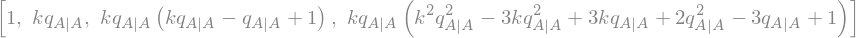

In [83]:
# 1, k_AA and k_AA**2
E_A = [simplify(summation(k_AA**i*dist_A, (k_AA, 0, k)).args[0].args[0]) for i in range(4)]
E_A

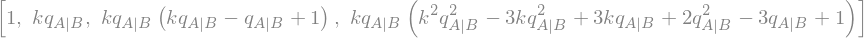

In [84]:
# 1, k_AB, and k_AB**2
E_B = [simplify(summation(k_AB**i*dist_B, (k_AB, 0, k)).args[0].args[0]) for i in range(4)]
E_B

### 🌷 equation (5-6) & (9-12) 🌷

In [85]:
core = factor(k_AB*f_A/(k_AB*f_A + k_BB*f_B))
core = core.series(omega, x0 = 0, n = 2).as_ordered_terms() # linear term, constant term and O (omega**2)
core_A_plus = [collect(expand(factor(core[j].subs({k_BB: k - k_AB}))), k_AB) for j in [1, 0]] # constant term and linear term
p_A_plus = [p_B*factor(np.sum([core_A_plus[j].coeff(k_AB, i)*E_B[i] for i in range(3)])) for j in range(2)] # equation (5)
core_AA_plus = [collect(expand(2*k_AB/(k*N)*factor(core[j].subs({k_BB: k - k_AB}))), k_AB) for j in [1, 0]]
p_AA_plus = [p_B*factor(np.sum([core_AA_plus[j].coeff(k_AB, i)*E_B[i] for i in range(4)])) for j in range(2)] # equation (6)

In [86]:
core = factor(k_BA*g_B/(k_AA*g_A + k_BA*g_B))
core = core.series(omega, x0 = 0, n = 2).as_ordered_terms() # linear term, constant term and O(omega**2)
core_A_minus = [collect(expand(factor(core[j].subs({k_BA: k - k_AA}))), k_AA) for j in [1, 0]] # constant term and linear term
p_A_minus = [p_A*factor(np.sum([core_A_minus[j].coeff(k_AA, i)*E_A[i] for i in range(3)])) for j in range(2)] # equation (9)
core_AA_minus = [collect(expand(2*k_AA/(k*N)*factor(core[j].subs({k_BA: k - k_AA}))), k_AA) for j in [1, 0]]
p_AA_minus = [p_A*factor(np.sum([core_AA_minus[j].coeff(k_AA, i)*E_A[i] for i in range(4)])) for j in range(2)] # equation (10)

In [87]:
# diff_p_A = [simplify(1/N*(x - y)) for x, y in zip(p_A_plus, p_A_minus)] # equation (11)
# diff_p_AA = [simplify(x - y) for x, y in zip(p_AA_plus, p_AA_minus)] # equation (12)
# # constant term of diff_p_A is zero
# diff_p_A[0].subs({q_AA: 1 - q_BA}).subs({p_A: p_BA/q_BA, p_B: p_AB/q_AB}).subs({p_BA: p_AB}) 

In [88]:
p_A_plus = np.sum([p_A_plus[j].subs({p_B: p_AB/q_AB}) for j in range(2)])
p_A_minus = np.sum([p_A_minus[j].subs({p_A: p_BA/q_BA}) for j in range(2)])
diff_p_A = simplify(1/N*(p_A_plus - p_A_minus)) # equation (11)

p_AA_plus = np.sum([p_AA_plus[j].subs({p_B: p_AB/q_AB}) for j in range(2)])
p_AA_minus = np.sum([p_AA_minus[j].subs({p_A: p_BA/q_BA}) for j in range(2)])
diff_p_AA = simplify(p_AA_plus - p_AA_minus) # equation (12)

In [89]:
# constant term of diff_p_A is zero
factor(diff_p_A.subs({omega: 0}).subs({p_BA: p_AB}).subs({q_BA: 1 - q_AA}))

### 🌷 equation (14) 🌷

In [90]:
identity_0 = factor(diff_p_AA.subs({omega: 0}).subs({p_BA: p_AB}).subs({q_BA: 1 - q_AA}))
identity_0 = factor_list(fraction(identity_0)[0])[1][1][0]
identity_0

### 🌷 equation (16) 🌷

In [91]:
identity_1 = fraction(factor(identity_0.subs({q_AB: p_A/p_B*q_BA}).subs({q_BA: 1 - q_AA}).subs({p_B: 1 - p_A})))[0]
identity_1

## fixation probability

given $i$ A individuals
> * the probability that the number of A individuals reduces by one is $T_A^{-}(i)$
> * the probability that the number of A individuals increases by one is $T_A^{+}(i)$

\begin{dcases}
T_A^{-}(i) &= p_A\frac{kq_{BA}(i)g_B(i)}{kq_{AA}(i)g_A(i) + kq_{BA}g_B(i)} = p_A\frac{q_{BA}(i)g_B(i)}{q_{AA}(i)g_A(i) + q_{BA}g_B(i)}\\
T_A^{+}(i) &= p_B\frac{kq_{AB}(i)f_A(i)}{kq_{AB}(i)f_A(i) + kq_{BB}f_B(i)} = p_B\frac{q_{AB}(i)f_A(i)}{q_{AB}(i)f_A(i) + q_{BB}f_B(i)}
\end{dcases}

further (see Evolutionary Dynamics: Exploring the Equation of Life)

\begin{equation}
\rho_A = 1/\left[1 + \sum_{i = 1}^{N - 1}\prod_{j = 1}^{i}T_A^{-}(j)/T_A^{+}(j)\right]
\end{equation}

In [92]:
T_A_backward = p_A*q_BA*g_B/(q_AA*g_A + q_BA*g_B) 
T_A_forward = p_B*q_AB*f_A/(q_AB*f_A + q_BB*f_B)

In [93]:
# p_AB = p_A*q_BA = p_B*q_AB, 1 = p_A + p_B = q_AA + q_BA = q_AB + q_BB
ratio = factor(T_A_backward/T_A_forward).series(omega, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({p_A: p_AB/q_BA, p_B: p_AB/q_AB, q_BA: 1 - q_AA, q_AB: 1 - q_BB}))

In [94]:
# substitutions
q_AA_sub = p_A + 1/(k - 1) - p_A/(k - 1) # Equation (16)
q_BB_sub = p_B + 1/(k - 1) - p_B/(k - 1) # similar to Equation (16)
q_BA_sub = q_BB_sub - 1/(k - 1) # Equation (17)
q_AB_sub = q_AA_sub - 1/(k - 1) # Equation (17)
ratio = factor(ratio.subs({q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))

### from discrete to continuous

> Riemann sum to Riemann integral
> 
> 🍨 $\omega \sigma_{ij} = 1 - \text{ratio}$ 🍨

\begin{aligned}
\rho_A &= 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\prod_{j = 1}^{i}(1 - \omega\sigma_{ij})] \\
&\approx 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}(1 - \displaystyle\sum_{j = 1}^{i}\omega\sigma_{ij})] = 1/(N - \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\omega\sigma_{ij}) \\
&\approx 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\omega\sigma_{ij})/N^2 
= 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\omega\sigma_{ij}dydx)/(N^2dydx) 
\end{aligned}

> 🍨 $\rho_A \approx 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)/(N^2dydx) 
= 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)$ 🍨

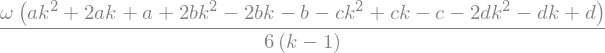

In [95]:
x, y = symbols('x, y', nonnegative = True)
ratio = factor(ratio.subs({p_A: x, p_B: (1 - x)}))
addition_A = factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1))) # rho_A - 1/N
addition_A

### 🌷 equation (22) 🌷

In [96]:
flag_a = factor((1 - ratio)/omega)
flag_a = factor(flag_a.subs({p_A: i/N, p_B: (N - i)/N}))
flag_a = factor(flag_a.subs({i: N*x}))
flag_a = fraction(factor(integrate(integrate(flag.subs({x: y}), (y, 0, x)), (x, 0, 1))))[0]
flag_a = collect(collect(collect(collect(flag, a), b), c), d)
flag_a

### 🌷 equation (23) 🌷

In [97]:
flag_b = flag_a.subs({a: R, b: S, c: T, d: P}).subs({R: d, S: c, T: b, P: a})
flag_b

### 🌷 equation (24) 🌷

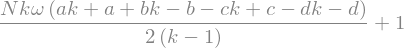

In [98]:
addition_B = addition_A.subs({a: R, b: S, c: T, d: P}).subs({R: d, S: c, T: b, P: a})
r = ((1/N + addition_A)/(1/N + addition_B)).series(omega, x0 = 0, n = 2) # Taylor expansion
r = r.removeO()
r = 1 + factor(r - 1)
r

### 🌷 equation (25 - 26) 🌷

In [99]:
flag_a_dg = flag_a.subs({a: R, b: S, c: T, d: P}).subs({R: b - c, S: - c, T: b, P: 0})
flag_a_dg = factor(flag_a_dg)
flag_a_dg